# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).


In [9]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
from collections import deque
import torch
from matplotlib import pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
def prelim_run():
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            #actions = np.ones([num_agents, action_size])
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
        print(scores)
#prelim_run()

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
AGENT_SEED = 136893
STATE_SIZE = 24*2
ACTION_SIZE = 2*2

agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, random_seed=AGENT_SEED)

In [8]:
def ddpg():
    scores_deque = deque(maxlen=100)
    scores = []
    i_episode = 0
    while True:
        i_episode += 1
        use_train_mode = i_episode % 250 != 0                            # visualize every so often
        env_info = env.reset(train_mode=use_train_mode)[brain_name]      # reset the environment
        states = env_info.vector_observations           # get the current state
        states = np.reshape(states, (1, -1))
        scores_this_ep = np.zeros(2)
        while True:
            actions = agent.act(states)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            
            env_info = env.step(np.reshape(actions, (2, -1)))[brain_name]           # send all actions to tne environment
            
            next_states = env_info.vector_observations         # get next state (for each agent)
            next_states = np.reshape(next_states, (1, -1))
            rewards = env_info.rewards
            dones = np.any(env_info.local_done)                        # see if episode finished
            
            agent.step(states, actions, np.sum(rewards), next_states, dones)
            
            states = next_states
            scores_this_ep += rewards
            
            if dones:                               # exit loop if episode finished
                break
            
        score = np.max(scores_this_ep)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.8f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if i_episode % 2500 == 0:
            torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_{i_episode}.pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_{i_episode}.pth')
        if sum(scores_deque) / len(scores_deque) >= 0.5:
            break
    return scores

scores = ddpg()


d:\documents\github\drlnd3\env\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.03810000	Score: 0.00
Episode 200	Average Score: 0.01340000	Score: 0.00
Episode 300	Average Score: 0.02330000	Score: 0.10
Episode 400	Average Score: 0.03050000	Score: 0.00
Episode 500	Average Score: 0.03590000	Score: 0.00
Episode 600	Average Score: 0.02940000	Score: 0.00
Episode 700	Average Score: 0.02240000	Score: 0.00
Episode 800	Average Score: 0.02590000	Score: 0.00
Episode 900	Average Score: 0.02040000	Score: 0.00
Episode 1000	Average Score: 0.02830000	Score: 0.00
Episode 1100	Average Score: 0.01360000	Score: 0.00
Episode 1200	Average Score: 0.02650000	Score: 0.09
Episode 1300	Average Score: 0.01080000	Score: 0.00
Episode 1400	Average Score: 0.02590000	Score: 0.00
Episode 1500	Average Score: 0.02680000	Score: 0.00
Episode 1600	Average Score: 0.01080000	Score: 0.00
Episode 1700	Average Score: 0.01270000	Score: 0.00
Episode 1800	Average Score: 0.01990000	Score: 0.00
Episode 1900	Average Score: 0.01980000	Score: 0.00
Episode 2000	Average Score: 0.01070000	S

Episode 16000	Average Score: 0.00000000	Score: 0.00
Episode 16100	Average Score: 0.00000000	Score: 0.00
Episode 16200	Average Score: 0.00000000	Score: 0.00
Episode 16300	Average Score: 0.00000000	Score: 0.00
Episode 16400	Average Score: 0.00000000	Score: 0.00
Episode 16500	Average Score: 0.00000000	Score: 0.00
Episode 16600	Average Score: 0.00000000	Score: 0.00
Episode 16700	Average Score: 0.00000000	Score: 0.00
Episode 16800	Average Score: 0.00000000	Score: 0.00
Episode 16900	Average Score: 0.00000000	Score: 0.00
Episode 17000	Average Score: 0.00000000	Score: 0.00
Episode 17100	Average Score: 0.00000000	Score: 0.00
Episode 17200	Average Score: 0.00000000	Score: 0.00
Episode 17300	Average Score: 0.00000000	Score: 0.00
Episode 17400	Average Score: 0.00000000	Score: 0.00
Episode 17500	Average Score: 0.00000000	Score: 0.00
Episode 17600	Average Score: 0.00000000	Score: 0.00
Episode 17700	Average Score: 0.00000000	Score: 0.00
Episode 17800	Average Score: 0.00000000	Score: 0.00
Episode 1790

Episode 31700	Average Score: 0.00000000	Score: 0.00
Episode 31800	Average Score: 0.00000000	Score: 0.00
Episode 31900	Average Score: 0.00000000	Score: 0.00
Episode 32000	Average Score: 0.00000000	Score: 0.00
Episode 32100	Average Score: 0.00000000	Score: 0.00
Episode 32200	Average Score: 0.00000000	Score: 0.00
Episode 32300	Average Score: 0.00000000	Score: 0.00
Episode 32400	Average Score: 0.00000000	Score: 0.00
Episode 32500	Average Score: 0.00000000	Score: 0.00
Episode 32600	Average Score: 0.00000000	Score: 0.00
Episode 32700	Average Score: 0.00000000	Score: 0.00
Episode 32800	Average Score: 0.00000000	Score: 0.00
Episode 32900	Average Score: 0.00000000	Score: 0.00
Episode 33000	Average Score: 0.00000000	Score: 0.00
Episode 33100	Average Score: 0.00000000	Score: 0.00
Episode 33200	Average Score: 0.00000000	Score: 0.00
Episode 33300	Average Score: 0.00000000	Score: 0.00
Episode 33400	Average Score: 0.00000000	Score: 0.00
Episode 33500	Average Score: 0.00000000	Score: 0.00
Episode 3360

Episode 47400	Average Score: 0.00000000	Score: 0.00
Episode 47500	Average Score: 0.00000000	Score: 0.00
Episode 47600	Average Score: 0.00000000	Score: 0.00
Episode 47700	Average Score: 0.00000000	Score: 0.00
Episode 47800	Average Score: 0.00000000	Score: 0.00
Episode 47900	Average Score: 0.00000000	Score: 0.00
Episode 48000	Average Score: 0.00000000	Score: 0.00
Episode 48100	Average Score: 0.00000000	Score: 0.00
Episode 48200	Average Score: 0.00000000	Score: 0.00
Episode 48300	Average Score: 0.00000000	Score: 0.00
Episode 48400	Average Score: 0.00000000	Score: 0.00
Episode 48500	Average Score: 0.00000000	Score: 0.00
Episode 48600	Average Score: 0.00000000	Score: 0.00
Episode 48700	Average Score: 0.00000000	Score: 0.00
Episode 48800	Average Score: 0.00000000	Score: 0.00
Episode 48900	Average Score: 0.00000000	Score: 0.00
Episode 49000	Average Score: 0.00000000	Score: 0.00
Episode 49100	Average Score: 0.00000000	Score: 0.00
Episode 49200	Average Score: 0.00000000	Score: 0.00
Episode 4930

Episode 63100	Average Score: 0.01500000	Score: 0.00
Episode 63200	Average Score: 0.01900000	Score: 0.00
Episode 63300	Average Score: 0.01100000	Score: 0.00
Episode 63400	Average Score: 0.03380000	Score: 0.00
Episode 63500	Average Score: 0.02100000	Score: 0.00
Episode 63600	Average Score: 0.03700000	Score: 0.10
Episode 63700	Average Score: 0.02280000	Score: 0.00
Episode 63800	Average Score: 0.01700000	Score: 0.00
Episode 63900	Average Score: 0.00000000	Score: 0.00
Episode 64000	Average Score: 0.00180000	Score: 0.00
Episode 64100	Average Score: 0.01140000	Score: 0.00
Episode 64200	Average Score: 0.03900000	Score: 0.00
Episode 64300	Average Score: 0.02280000	Score: 0.10
Episode 64400	Average Score: 0.04620000	Score: 0.00
Episode 64500	Average Score: 0.05040000	Score: 0.10
Episode 64600	Average Score: 0.04280000	Score: 0.10
Episode 64700	Average Score: 0.05730000	Score: 0.10
Episode 64800	Average Score: 0.06720000	Score: 0.09
Episode 64900	Average Score: 0.05250000	Score: 0.00
Episode 6500

Episode 78800	Average Score: 0.07500000	Score: 0.09
Episode 78900	Average Score: 0.07140000	Score: 0.10
Episode 79000	Average Score: 0.10510000	Score: 0.10
Episode 79100	Average Score: 0.07770000	Score: 0.10
Episode 79200	Average Score: 0.07970000	Score: 0.00
Episode 79300	Average Score: 0.07850000	Score: 0.09
Episode 79400	Average Score: 0.08500000	Score: 0.09
Episode 79500	Average Score: 0.08440000	Score: 0.09
Episode 79600	Average Score: 0.03060000	Score: 0.00
Episode 79700	Average Score: 0.10910000	Score: 0.10
Episode 79800	Average Score: 0.09010000	Score: 0.10
Episode 79900	Average Score: 0.08730000	Score: 0.00
Episode 80000	Average Score: 0.06850000	Score: 0.00
Episode 80100	Average Score: 0.07590000	Score: 0.00
Episode 80200	Average Score: 0.09070000	Score: 0.19
Episode 80300	Average Score: 0.09430000	Score: 0.10
Episode 80400	Average Score: 0.08550000	Score: 0.10
Episode 80500	Average Score: 0.08340000	Score: 0.00
Episode 80600	Average Score: 0.08790000	Score: 0.20
Episode 8070

Episode 94500	Average Score: 0.14870000	Score: 0.10
Episode 94600	Average Score: 0.11470000	Score: 0.00
Episode 94700	Average Score: 0.18010000	Score: 0.09
Episode 94800	Average Score: 0.17270000	Score: 0.10
Episode 94900	Average Score: 0.21860000	Score: 0.20
Episode 95000	Average Score: 0.19770000	Score: 0.09
Episode 95100	Average Score: 0.18800000	Score: 0.10
Episode 95200	Average Score: 0.17370000	Score: 0.20
Episode 95300	Average Score: 0.11320000	Score: 0.00
Episode 95400	Average Score: 0.19740000	Score: 0.30
Episode 95500	Average Score: 0.22730000	Score: 0.20
Episode 95600	Average Score: 0.18520000	Score: 0.10
Episode 95700	Average Score: 0.16250000	Score: 0.10
Episode 95800	Average Score: 0.20030000	Score: 0.19
Episode 95900	Average Score: 0.21210000	Score: 0.19
Episode 96000	Average Score: 0.20280000	Score: 0.40
Episode 96100	Average Score: 0.19530000	Score: 0.10
Episode 96200	Average Score: 0.17420000	Score: 0.10
Episode 96300	Average Score: 0.19970000	Score: 0.29
Episode 9640

NameError: name 'plt' is not defined

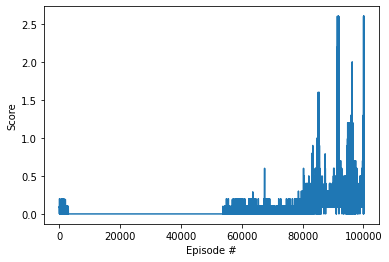

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_final.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_final.pth')

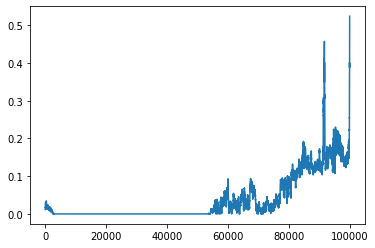

In [12]:
rolling_avg = np.convolve(scores, np.ones(100), 'valid') / 100

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(rolling_avg)
plt.show()

In [ ]:
# ok from here on untested

In [ ]:
agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, random_seed=AGENT_SEED)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_final.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_final.pth'))
agent.actor_local.eval()
agent.critic_local.eval()

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
state = preprocess_state(env_info.vector_observations) # get the current state (for each agent)
score = 0                                              # initialize the score (for each agent)
while True:
    action = agent.act(state)
    action = np.clip(action, -1, 1)                    # all actions between -1 and 1
    env_info = env.step(action)[brain_name]            # send all actions to tne environment
    next_state = preprocess_state(                     # get next state (for each agent)
        env_info.vector_observations
    )
    reward = env_info.rewards[0]                       # get reward (for each agent)
    done = env_info.local_done                         # see if episode finished

    state = next_state                                 # roll over states to next time step
    score += reward                                    # update the score (for each agent)
    if np.any(done):                                   # exit loop if episode finished
        break
        
print(score)
